In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from momaapi import MOMA
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

/opt/conda/envs/faiss/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [89]:
# VERSION: DO NOT ALLOW GAP

# def DTW(p, q, sim):
#     D = np.zeros((len(p) + 1, len(q) + 1))
#     D[0,:] = -1000000. # -inf
#     D[:,0] = -1000000. # -inf
#     D[0,0] = 0

#     for i in range(1, len(p)+1):
#         for j in range(1, len(q)+1):
#             s = sim[p[i-1], q[j-1]]
#             D[i,j] = s + max(D[i-1,j], D[i,j-1], D[i-1,j-1])

#     path = backtrack(p, q, sim, D)

#     return D, path # 알아서 path length에 대해 normalize

# def backtrack(p, q, sim, D):
#     path = []
#     i, j = len(p), len(q)

#     while i >= 1 or j >= 1:
#         path.append((i-1, j-1))
#         s = sim[p[i-1], q[j-1]]
#         if D[i,j] == s + D[i-1,j]:
#             i = i - 1
#         elif D[i,j] == s + D[i, j-1]:
#             j = j - 1
#         elif D[i,j] == s + D[i-1, j-1]:
#             i, j = i - 1, j - 1
#         else:
#             raise ValueError
        
#     return path[::-1]


In [2]:
# VERSION: ALLOW GAP

def DTW(p, q, sim):
    D = np.zeros((len(p) + 1, len(q) + 1))

    for i in range(1, len(p)+1):
        for j in range(1, len(q)+1):
            s = sim[p[i-1], q[j-1]]
            D[i,j] = max(D[i-1,j], D[i,j-1], D[i-1,j-1] + s)

    path, count = backtrack(p, q, sim, D)

    return D, path, count

def backtrack(p, q, sim, D):
    path, count = [], 0
    i, j = len(p), len(q)

    while i >= 1 and j >= 1:
        path.append((i-1, j-1))
        s = sim[p[i-1], q[j-1]]
        if D[i,j] == D[i-1,j]:
            i = i -1
        elif D[i,j] == D[i,j-1]:
            j = j - 1
        elif D[i,j] == D[i-1,j-1] + s:
            i, j = i - 1, j - 1
            count += 1
        else:
            raise ValueError
        
    return path[::-1], count

In [3]:
# PREPROCESSING

moma = MOMA(dir_moma="/data/dir_moma/", paradigm="standard")

vid2seq = {}   # activity id -> sub-activity sequence
sid2cname = {} # sub-activity id -> sub-activity class name
for split in ["train", "val", "test"]:
    ids_act = moma.get_ids_act(split=split)
    for act in tqdm(moma.get_anns_act(ids_act=ids_act), desc=f"PREPROCESSING ({split})"):
        sact_seq = []
        for sact in moma.get_anns_sact(ids_sact=act.ids_sact):
            sid2cname[sact.cid] = sact.cname
            sact_seq.append(sact.cid)
        vid2seq[act.id] = np.array(sact_seq)

sid2cemb = {} # sub-activity id -> sub-activity caption embedding
sbert = SentenceTransformer("all-MiniLM-L6-v2")
for vid, cname in sid2cname.items():
    cemb = sbert.encode(cname)
    cemb = torch.from_numpy(cemb).float()
    sid2cemb[vid] = cemb
    
cembs = torch.zeros(len(sid2cemb), 384)
for idx, emb in sid2cemb.items():
    cembs[idx] = emb

cembs = F.normalize(cembs, dim=-1)
sim = torch.mm(cembs, cembs.t())
sim = sim.numpy()

PREPROCESSING (test): 100%|██████████| 282/282 [00:05<00:00, 52.20it/s] 


p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [42 65 64 65 65 64 65 65 64 65 41 42 65 64 64 65 64 64 64 64 64 41] (22)
normalized_distance: 0.007156852218839858


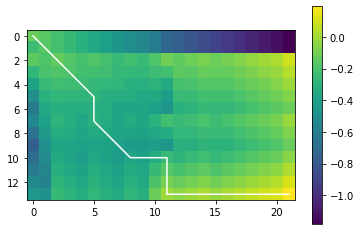

In [25]:
# VERSION: DO NOT ALLOW GAP

# ids_act_train = moma.get_ids_act(split="train")
# ids_act_val = moma.get_ids_act(split="val")
# ids_act_test = moma.get_ids_act(split="test")
# ids_act = ids_act_train + ids_act_val + ids_act_test

# for vid_i in ids_act:
#     for vid_j in ids_act:
#         if vid_i == vid_j:
#             continue
#         p = vid2seq[vid_i]
#         q = vid2seq[vid_j]
#         print(f"p: {p} ({len(p)})")
#         print(f"q: {q} ({len(q)})")

#         D, path = DTW(p, q, sim)
        
#         normalized_distance = D[len(p), len(q)] / len(path) 
#         print(f"normalized_distance: {normalized_distance}")

#         plt.imshow(D[1:,1:], interpolation="nearest")
#         plt.plot([p[1] for p in path], [p[0] for p in path], "w")
#         plt.colorbar()
#         plt.show()

#         break
#     break

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [42 65 64 65 65 64 65 65 64 65 41 42 65 64 64 65 64 64 64 64 64 41] (22)
[(2, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (7, 3), (7, 4), (8, 4), (9, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (11, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (12, 20), (13, 21)]
normalized_distance: 0.05998041667044163
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 7), (2, 8), (2, 9), (3, 9), (4, 9), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 11), (11, 12), (12, 12), (13, 12), (14, 12), (15, 12), (16, 12), (17, 12), (18, 12), (19, 12), (20, 12), (21, 13)]
normalized_distance: 0.05998041667044163 0.0


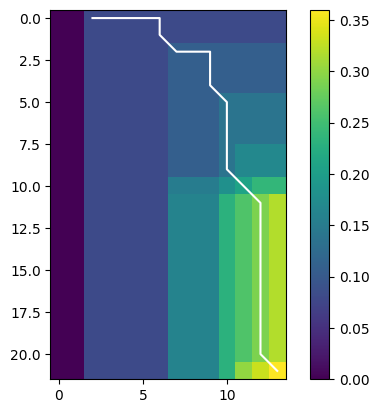

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [77 77 75 81 77 77 76 77 75 77 75 77 76 77 77 76 77 76] (18)
[(0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (11, 14), (12, 15), (12, 16), (13, 17)]
normalized_distance: 0.34851184487342834
[(2, 0), (3, 1), (4, 2), (5, 3), (6, 4), (7, 5), (8, 6), (9, 7), (10, 8), (11, 9), (12, 10), (13, 11), (14, 11), (15, 12), (16, 12), (17, 13)]
normalized_distance: 0.34851184487342834 0.0


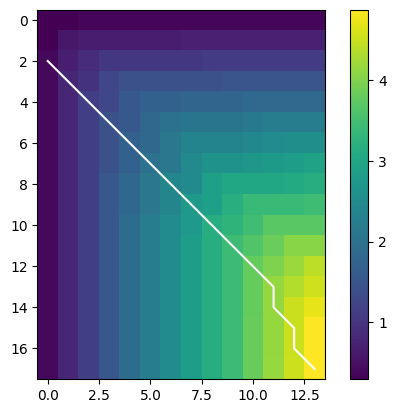

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [80 79 80 79 79 79 79 79 79 79 79 80 79 80 73 73 73 73 80 73 80 73 73 80
 73 73 73] (27)
[(0, 0), (0, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19), (10, 20), (11, 21), (12, 22), (13, 23), (13, 24), (13, 25), (13, 26)]
normalized_distance: 0.14900473452040128
[(0, 0), (1, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 3), (14, 4), (15, 5), (16, 6), (17, 7), (18, 8), (19, 9), (20, 10), (21, 11), (22, 12), (23, 13), (24, 13), (25, 13), (26, 13)]
normalized_distance: 0.14900473452040128 0.0


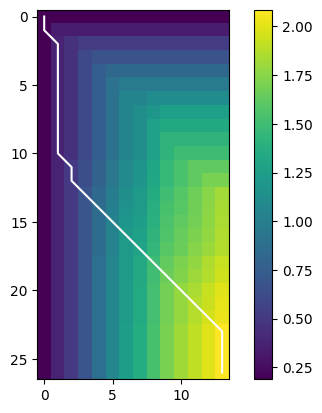

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [38] (1)
[(2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0)]
normalized_distance: 0.03868290036916733
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13)]
normalized_distance: 0.03868290036916733 0.0


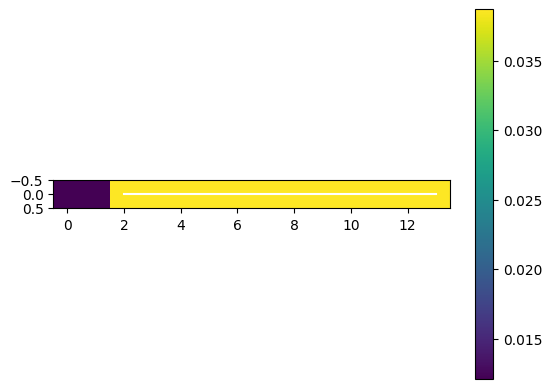

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [18 18 18 18 18 18 18 18 18 18] (10)
[(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 5), (8, 6), (9, 7), (9, 8), (9, 9), (10, 9), (11, 9), (12, 9), (13, 9)]
normalized_distance: 0.07285521924495697
[(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (5, 7), (6, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (8, 13), (9, 13)]
normalized_distance: 0.07285521924495697 0.0


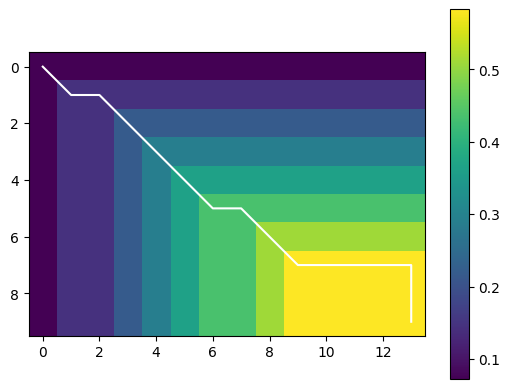

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [22 22 24 22 22 62 22 62 62 62 22 22 22 62 22 22 62] (17)
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (7, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (12, 14), (12, 15), (13, 16)]
normalized_distance: 0.899787289755685
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 7), (9, 7), (10, 8), (11, 9), (12, 10), (13, 11), (14, 12), (15, 12), (16, 13)]
normalized_distance: 0.899787289755685 0.0


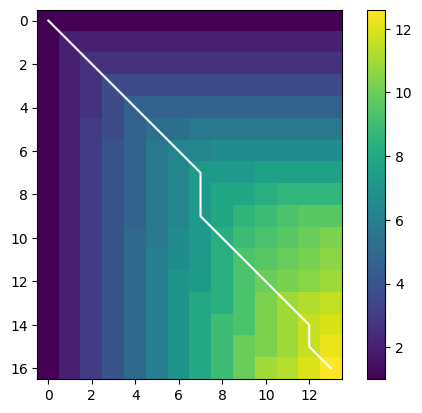

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [56 56 56 56 56] (5)
[(2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 1), (9, 1), (10, 2), (11, 3), (12, 4), (13, 4)]
normalized_distance: 0.18942409753799438
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 7), (1, 8), (1, 9), (2, 10), (3, 11), (4, 12), (4, 13)]
normalized_distance: 0.18942409753799438 0.0


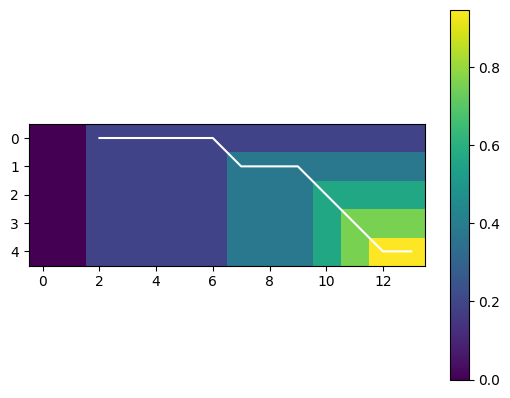

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [37 36 38 38 38] (5)
[(2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 1), (9, 1), (10, 2), (11, 3), (12, 4), (13, 4)]
normalized_distance: 0.06152391880750656
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 7), (1, 8), (1, 9), (2, 10), (3, 11), (4, 12), (4, 13)]
normalized_distance: 0.06152391880750656 0.0


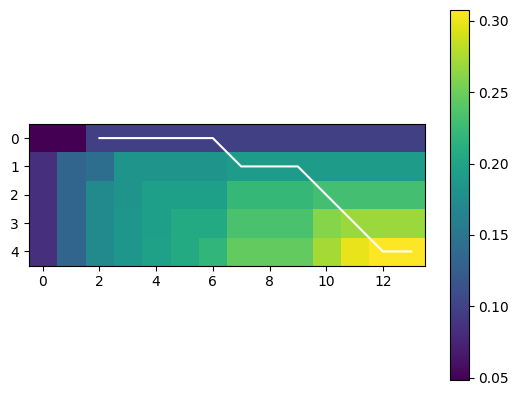

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [8 8] (2)
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
normalized_distance: 0.2598230242729187
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13)]
normalized_distance: 0.2598230242729187 0.0


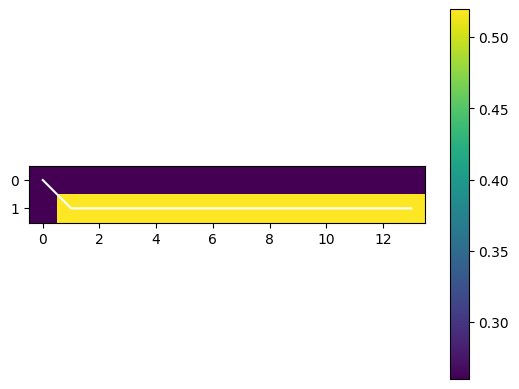

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [36 36 36 38] (4)
[(2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 1), (9, 1), (10, 2), (11, 3), (12, 3), (13, 3)]
normalized_distance: 0.0799275804311037
[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 7), (1, 8), (1, 9), (2, 10), (3, 11), (3, 12), (3, 13)]
normalized_distance: 0.0799275804311037 0.0


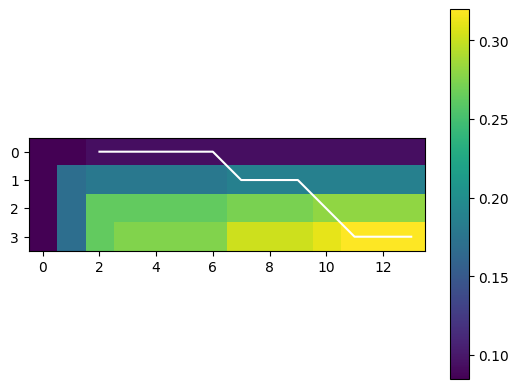

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [61 61] (2)
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
normalized_distance: 0.3825260400772095
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13)]
normalized_distance: 0.3825260400772095 0.0


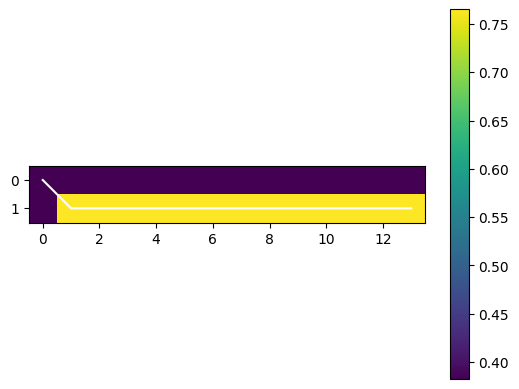

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [36 39 38 38 36 38 38 38 38 36 36 39 36 38] (14)
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13)]
normalized_distance: 0.04973453123654638
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13)]
normalized_distance: 0.04973453123654638 0.0


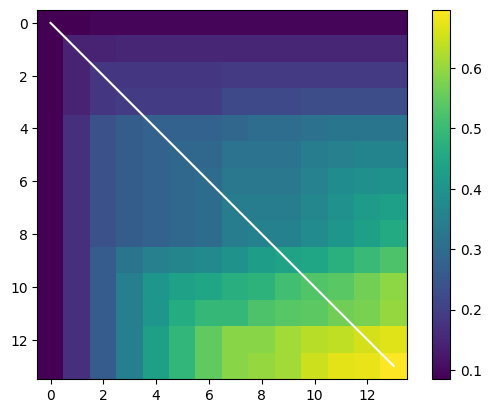

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [ 0 88  1] (3)
[(0, 0), (1, 0), (2, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2)]
normalized_distance: 0.09621842453877132
[(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13)]
normalized_distance: 0.09621842453877132 0.0


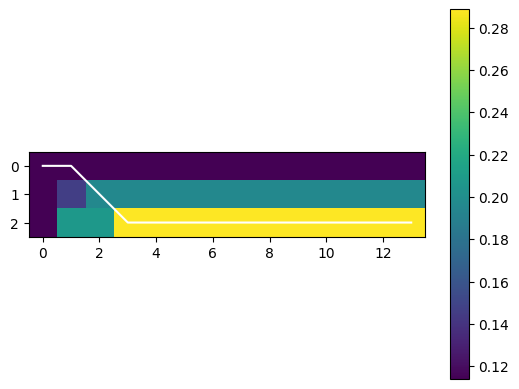

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [11 48] (2)
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
normalized_distance: 0.019524925388395786
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13)]
normalized_distance: 0.019524925388395786 0.0


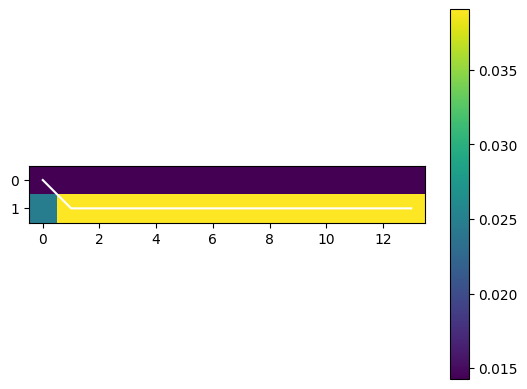

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [62 62 62 62 22 62 62 62 62 62 62 22 24 22 24 24 22 22 23 24 22 23 24 23
 23] (25)
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 11), (5, 12), (6, 13), (7, 14), (7, 15), (8, 16), (9, 17), (10, 18), (11, 19), (12, 20), (12, 21), (13, 22), (13, 23), (13, 24)]
normalized_distance: 0.7891500209059034
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 5), (12, 5), (13, 6), (14, 7), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (20, 12), (21, 12), (22, 13), (23, 13), (24, 13)]
normalized_distance: 0.7891500209059034 0.0


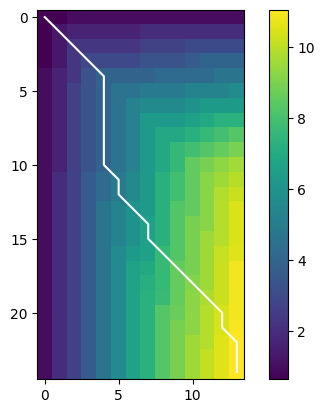

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [11 48] (2)
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
normalized_distance: 0.019524925388395786
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13)]
normalized_distance: 0.019524925388395786 0.0


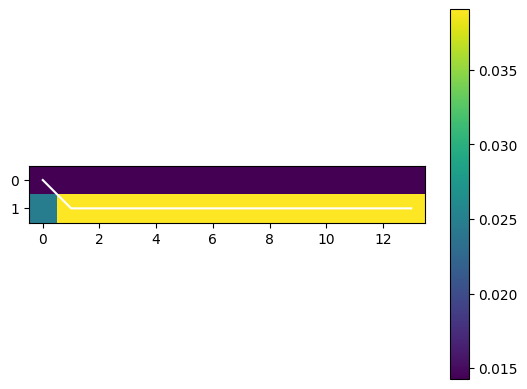

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [73 73 73 73 80 79 80 80 80 73] (10)
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 9), (11, 9), (12, 9), (13, 9)]
normalized_distance: 0.16178953871130944
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13)]
normalized_distance: 0.16178953871130944 0.0


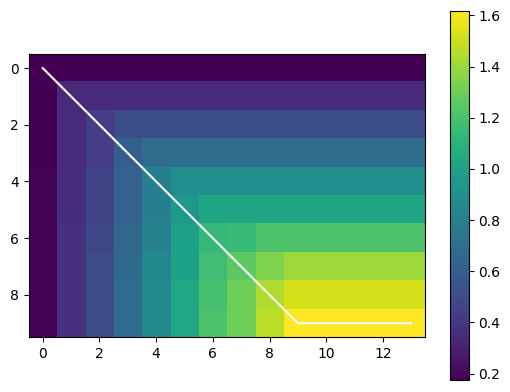

p: [22 22 62 22 22 22 22 62 22 22 62 62 62 62] (14)
q: [43 43] (2)
[(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
normalized_distance: 0.10476554930210114
[(0, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13)]
normalized_distance: 0.10476554930210114 0.0


KeyboardInterrupt: 

In [8]:
# VERSION: ALLOW GAP

ids_act_train = moma.get_ids_act(split="train")
ids_act_val = moma.get_ids_act(split="val")
ids_act_test = moma.get_ids_act(split="test")
ids_act = ids_act_train + ids_act_val + ids_act_test

for vid_i in ids_act:
    for vid_j in ids_act:
        if vid_i == vid_j:
            continue
        p = vid2seq[vid_i]
        q = vid2seq[vid_j]
        print(f"p: {p} ({len(p)})")
        print(f"q: {q} ({len(q)})")

        D, path, count = DTW(p, q, sim)
        print(path)
        
        normalized_distance1 = D[len(p), len(q)] / count
        print(f"normalized_distance: {normalized_distance1}")

        D, path, count = DTW(q, p, sim)
        print(path)
        
        normalized_distance2 = D[len(q), len(p)] / count
        print(f"normalized_distance: {normalized_distance2} {abs(normalized_distance1 - normalized_distance2)}")

        plt.imshow(D[1:,1:], interpolation="nearest")
        plt.plot([p[1] for p in path], [p[0] for p in path], "w")
        plt.colorbar()
        plt.show()

        
    break

In [48]:
# VERSION: DO NOT ALLOW GAP

query = vid2seq["24q1O3M9xiw"]
# ref = vid2seq["m0MtHFfhhFs"] # top 1
# ref = vid2seq["OXxcLxvdHBc"] # top 2
# ref = vid2seq["V_1cchOYMFw"] # top 3
ref = vid2seq["Yg2oElKPCas"] # top 4 (goal)

D, path = DTW(query, ref, sim)
normalized_distance = D[len(query), len(ref)] / len(path) 
print(f"distance: {D[len(query), len(ref)]} length: {len(path)}")
print(f"normalized_distance: {normalized_distance}")

distance: 42.111726105213165 length: 50
normalized_distance: 0.8422345221042633


In [41]:
# VERSION: ALLOW GAP

query = vid2seq["24q1O3M9xiw"]
# ref = vid2seq["m0MtHFfhhFs"] # top 1
# ref = vid2seq["OXxcLxvdHBc"] # top 2
# ref = vid2seq["V_1cchOYMFw"] # top 3
ref = vid2seq["Yg2oElKPCas"] # top 4 (goal)

D, path, count = DTW(query, ref, sim)
normalized_distance = D[len(query), len(ref)] / count
print(f"distance: {D[len(query), len(ref)]} count: {count}")
print(f"normalized_distance: {normalized_distance}")

distance: 19.160077810287476 count: 22
normalized_distance: 0.8709126277403398


In [93]:
query = vid2seq["sLx08J_2YrI"]
# ref = vid2seq["FdcEJvTTHy8"]
# ref = vid2seq["5bjr7DgN_nk"]
# ref = vid2seq["Yki5bj7WYhU"]
ref = vid2seq["RdC2rVhrnwc"]

D, path = DTW(query, ref, sim)
normalized_distance = D[len(query), len(ref)] / len(path) 
print(f"distance: {D[len(query), len(ref)]} length: {len(path)}")
print(f"normalized_distance: {normalized_distance}")


distance: 7.682176053524017 length: 8
normalized_distance: 0.9602720066905022
